# Mixture of experts Language Model presentation

## Noam Delbari & Stav Cohen

## 1 Background:

### 1.1 Standard Transformer

- Encoder/decoder stacks, multi-head self-attention, position encodings, residual + layer-norm.
- Emphasize the Feed-Forward Network (FFN) accounting for ~⅔ of parameters and FLOPs.

### 1.2 Mixture-of-Experts (MoE)

- Multiple specialist sub-nets compete; a gating network softly/hard-routes input to the best expert(s).

## 2 Switch transformer

### 2.1 Introduction: Motivation & Research Questions

TBD

### 2.2 Description & Architecture

- Switch Transformer extends the standard Transformer by replacing each dense feed-forward network with a Mixture-of-Experts layer which is being enabled by a lightweight gating network, letting only 1–2 experts process every token. This design keeps inference cost comparable to the dense baseline while unlocking trillion-parameter scale and superior quality on language, translation and multitask benchmarks
- Hands-on code snippets of the mode implementation, using equations and explanations: Forward pass, Switch Transformer Block and Switch Transformer model.

### 2.3 Experiments & Results

- Presenting Scaling & Efficiency results to motivate why use sparse experts
- Presenting  Ablation & Stability results to show that gating mechanism is capable for training large scale models
- Downstream fine-tuning results to show that the lower perplexity (compared to dense) during pre training has an effect over downstream tasks

### 2.4 Hands-on experiments

- Forward pass: Configure single expert per token and plot router decisions (Specificity of token types per expert)
- Training: Comparing switch model to dense baseline with equal number of active parameters and show that sparse model reaches lower validation loss faster
- Scaling and Efficiency miniature run

## 3 PEER (parameter efficient expert retrieval)

### 3.0 Terms

Just to be alligned, we'll explain here the following terms:

* **expert** - A specialized model or sub-model intended to handle a specific subset of data or tasks. It can be assumed as a small neural network (Usually some few neurons) which is a sub part of a layer.
* **product key** - A mechanism to enable efficient and effective matching between input data and the best-suited experts to process that data in a vast and diverse pool of potential experts

### 3.1 Introduction and motivation

- Based on the following paper: https://arxiv.org/pdf/2407.04153v1.
- The main idea here is the innovation of the sparse mixture-of-experts (MoE) model architectures using PEER (parameter efficient expert retrieval) layer.
- The PEER layer includes a vast number of tiny expert (over a million) and solves one of the main issues of the traditional models:
  - In traditional MoE models, the feedforward layers (FFW) have a linear increase in computational costs and activation memory as the hidden layer width grows.
  - However, in PEER, by enabling efficient utilization of a massive number of experts, it can support a further scaling of transformer models while maintaining almost the same computational efficiency.
  - It uses the product key technique for sparse retrieval.


### 3.2 Architecture and mathematical equalities

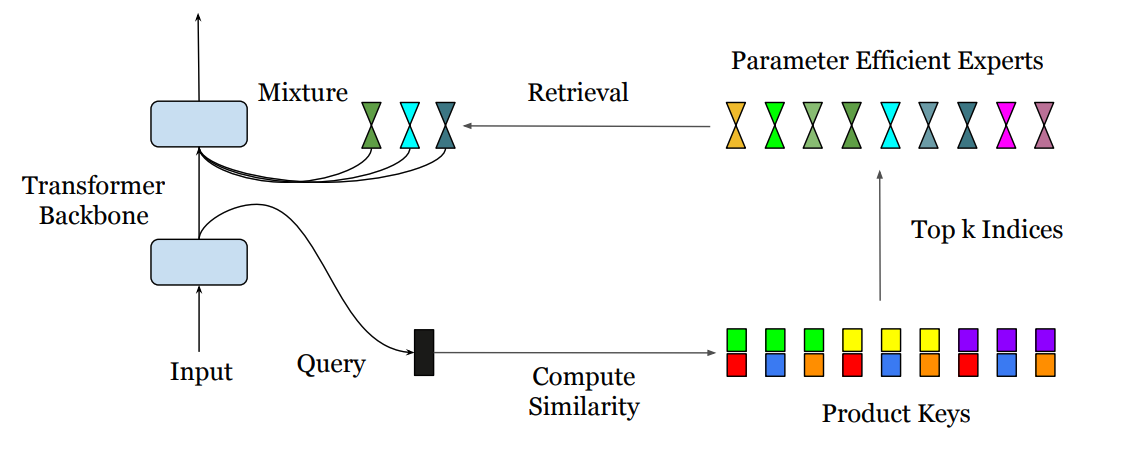

In [8]:
from IPython.display import Image
Image(filename="Peer_Layer.png", width=700, height=700)

The following is an illustration of the PEER layer:
* A PEER layer can be inserted in the middle of a transformer backbone or can be used to replace FFW layers
* Given the state vector x from the previous layer, a query
network $q$ maps it to a query vector $q(x)$, which is then compared with the product keys to compute the
router scores and to retrieve the top $k$ experts $e_1$, ..., $e_k$
* After the retrieved experts make their predictions
ei(x), their outputs are linearly combined using the softmax-normalized router scores as weights.

Formally, a PEER layer is a function $f:{R^n}\rightarrow{R^m}$ that consists of three parts:
* A pool of $N$ experts $E:=\{{e_i}\}_{i=1}^{N}$ where each expert $e_i:{R^n}\rightarrow{R^m}$ shares the same signature as $f$
* A matching set of $N$ produect keys: $K:=\{{k_i}\}_{i=1}^{N} \subset R^d$ ($d$ is the dimension of the vectors)
* A query network $q:{R^n}\rightarrow{R^d}$ that maps the input vector $x\in{R^n}$ to a query vector $q(x)$

The layer output is done by the following three steps:
1. Retrieving the top $k$ experts: The experts who their corresponding product keys have the highest inner products with the query $q(x)$: $I=T_k(\{q(x)^Tk_i\})_{i=1}^{N}$ while $T_k$ is the top $k$ operator
2. Actication: Applying nonlinear activations (such as softmax or sigmoid) to the query-key inner products of these
top $k$ experts to obtain the router scores: $g_i(x) = s(q(x)^Tk_i)$
3. Output: Computing the output by linearly combining the expert outputs weighted by the router scores: $f(x) = \sum_{{i}\in{I}}g_i(x)e_i(x)$.

Product key retrieval - Efficiency:
* Since $N$ can be a huge number $(N \geq 10^6)$, we don't want to compute it by the naive way
* Instead of using $N$ independent $d$-dimensional vectors as our keys $k_i$, we create them by concatenating vectors from two independent sets of $\frac{d}{2}$-dimensional sub-keys $C, C' \subset R^{\frac{d}{2}}$, $|C|=|C'|=\sqrt{N}$
* So in total $K = {\{[_{c'}^{c}]|c\in{C}, c'\in{C'}\}}$
* Hence we choose $N$ to be a perfect square and $d$ to be an even number
* Instead of comparing $q(x)$ to all $N$ keys in $K$ and selecting the top $k$ matches, we split the query vector $q(x)$ into two subqueries $q1$ and $q2$ and apply the top $k$ operations to the inner products between the sub-queries and sub-keys
respectively
* This results in a set of $k^2$ candidate keys, and it is mathematically guaranteed that the $k$ most similar keys to $q(x)$ from $K$ are in this candidate set so we can simply apply the top-k operator again to these $k^2$ inner products to get the top $k$ matching keys from the original set of product keys $K$
* Naive way runtime complexity: $O(Nd)$
* Efficient way runtime complexity: $O((\sqrt{N}+k^2)d)$


Parameter Efficient Experts and Multi-Head Retrieval:
* In other MoE architectures, the hidden layer of each expert is set to the same size as other FFW layers (A few and large experts)
* In PEER, every expert is a one hidden layer with a single neuron $e_i(x) := \sigma(u_i^Tx)v_i$ while $\sigma$ is a non-linear activation function
* Instead of making the size of individual experts different, we are using a multihead retrieval of $h$ independent query networks instead of one, each computes its own query and retrieves a separate set of $k$ experts: $f(x) := \sum_{i=1}^{h}f^i(x) = \sum_{i=1}^{h}\sum_{j \in I^i} g^j(x)e^j(x)$

Hyperparameters and loss function:
* There are three main hyperparameters to a standard MoE layer:
  1. $P$ - Total number of parameters
  2. $P_{active}$ - Total number of active parameters per token
  3. $P_{expert}$ - The size of a single expert
* Two more important terms:
  1. $D$ - Number of training tokens
  2. $G := \frac{P_{active}}{P_{experts}}$ - Number of active experts
* Now the loss function is $L(P, D, G) = c + (\frac{g}{G^\lambda} + a)\frac{1}{P^\alpha} + \frac{b}{D^\beta}$ ($a, b, c, g, \alpha, \beta, \lambda$ are constants)
* We would like to scale the total number of parameters, of experts and of the tokens, but NOT the number of active parameters, since the number of the active parameters affects the computational and runtime costs
* Since we want to increase the number of experts, we need to decrease the size of each expert if we do not increase the number of active parameters. Hence we need a large number of small experts
* In PEER, we set $P_{experts}$ to 1 and $P_{active}$ is the number of retrieval heads multiplied by the number of experts retrieved per head which is $hk$. Hence, in PEER layer the number of active experts is $G = hk$

### 3.3 Results of major experiments

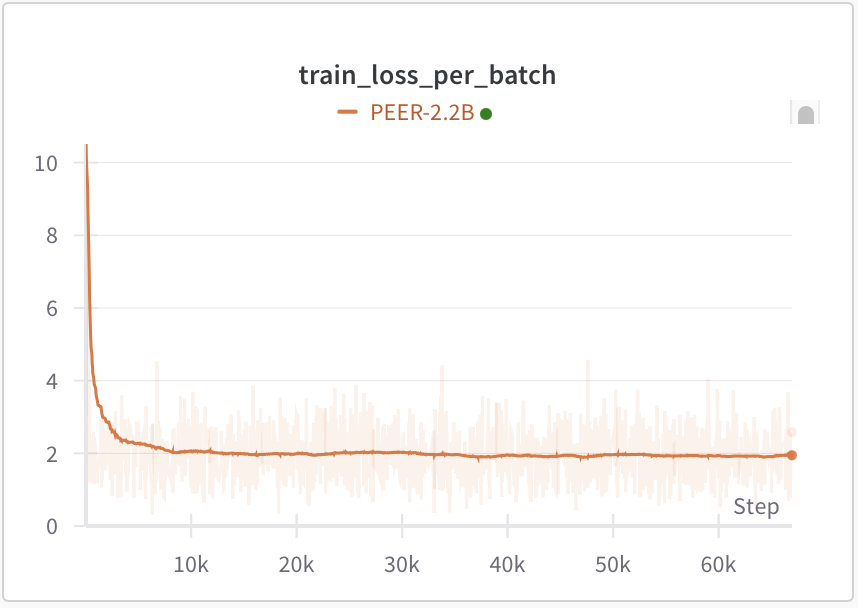

In [6]:
Image(filename="Peer_Experiment.png", width=600, height=600)

The following is a graph of the train loss per batch of their training process

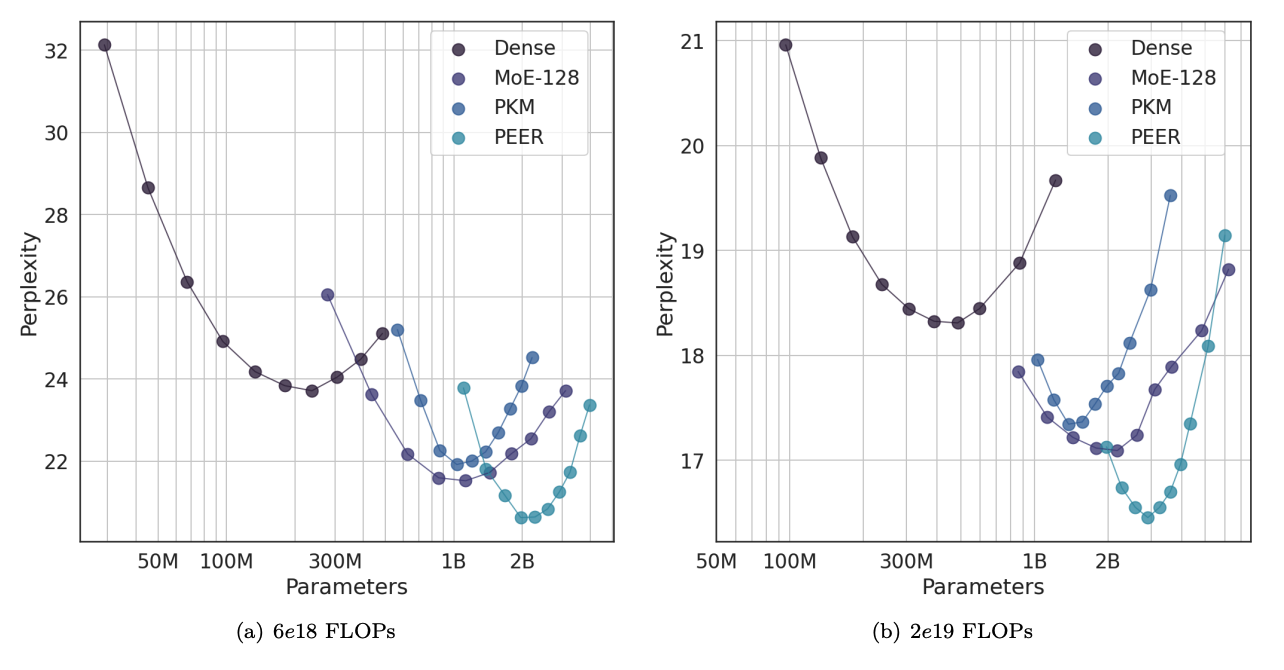

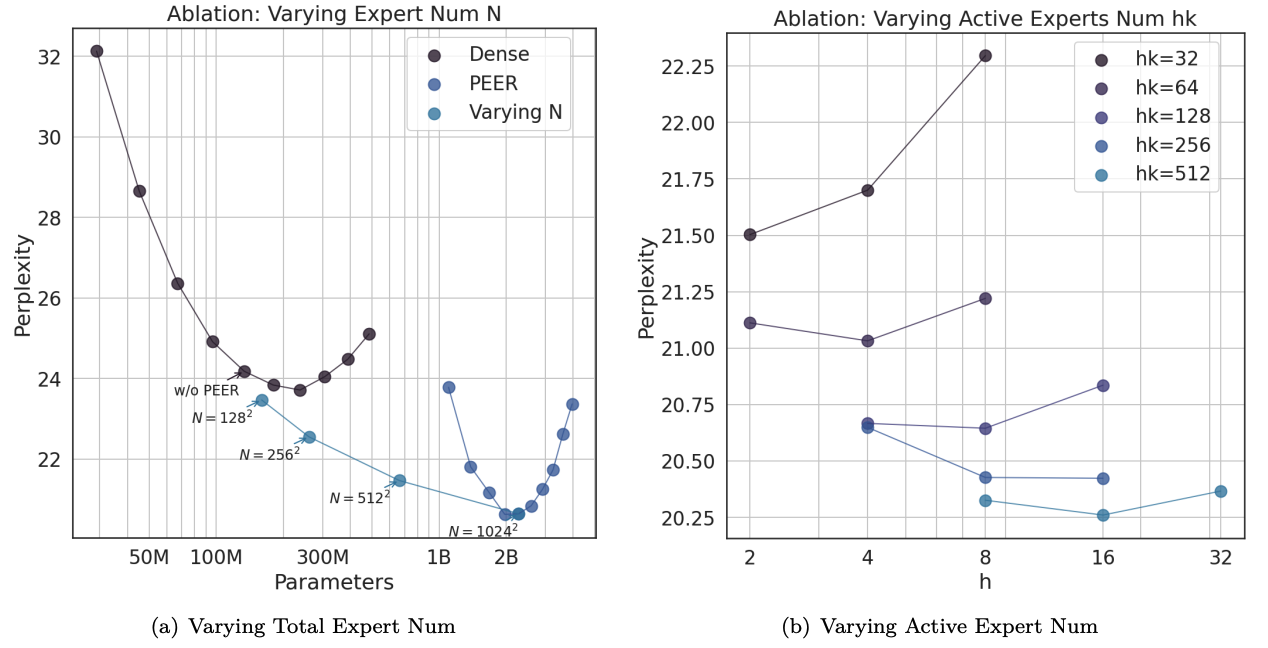

In [17]:
from IPython.display import HTML
display(Image(filename="6e18_6e19_FLOPs.png", width=700, height=500))
display(Image(filename="Varying_N_hk.png", width=700, height=500))

* The following graphs in the upper side shows the perplexity per number of parameters for 2e19 (more efficient computation) and 2e18 (less efficient computation) FLOP's, comparing different MoE models. It can be shown that PEER gives the lower perplexity and with the largest number of parameters
* The graph in the left-bottom side shows the perplexity per number of parameters of PEER models, comparing different number of total experts $N$. The size of the active experts $hk$ is always $128$
* The graph in the right-bottom side shows the perplexity per number of $h$ independent query networks (Active experts), while the total number of experts $N$ is always $1024^2$

### 3.4 Hands-on examples

-  Some hands on examples of basic peer layer implementation with the execution output in the notebook

In [5]:
print("Here we're going to make hands-on examples")

Here we're going to make hands-on examples
